In [64]:
import pandas as pd
import numpy as np


## the other data set uses FIPS (the 'COUNTY' field here) as an int, so we need
## to as well.
# dtypes = {
#     'COUNTY': str
# }


## this data is from 
df = pd.read_csv("vaccinetracking/vacc_data/data_county_current.csv",
    parse_dates=['DATE'])

## take only county-level data.
## rename to make usage of column clear
df = df[df.GEOFLAG == 'County'].rename(columns={'COUNTY': 'FIPS'})

## these are irrelevant because we're using the date field
df = df.drop(['STATE', 'WEEK', 'YEAR'], axis=1)

df[df.FIPS == 36061]

,STATE_NAME,COUNTY_NAME,FIPS,GEOFLAG,DATE,CASE_TYPE,CASES,POPN
11016,NY,New York,36061,County,2022-02-25,Booster,5.885270e+05,1628706.0
11017,NY,New York,36061,County,2022-02-25,Booster Coverage,3.613464e+01,1628706.0
11018,NY,New York,36061,County,2022-02-25,Complete,1.365710e+06,1628706.0
11019,NY,New York,36061,County,2022-02-25,Complete Coverage,8.385246e+01,1628706.0
11020,NY,New York,36061,County,2022-02-25,Partial,1.755507e+06,1628706.0
11021,NY,New York,36061,County,2022-02-25,Partial Coverage,1.000000e+02,1628706.0


According to the [codebook](https://github.com/bansallab/vaccinetracking/tree/main/vacc_data#codebook), the columns with "Coverage" are pre-computed percentages.

"Partial/ Partial Coverage" is anybody with at least 1 shot, not people with *only* one shot.

So essentially the unvax percentage is `1 - df[df.CASE_TYPE == 'Partial Coverage' ]`

I should use raw counts when joining...

## Question 1a (MVP): Is there a correlation between vax rate and covid fatality rate?

## Question 1b (MVP): Is there a correlation between income and vaccination rate?


In [65]:
partial_coverage = df[df.CASE_TYPE == 'Partial Coverage']

unvaxed_by_fips = df.loc[df.CASE_TYPE == 'Partial Coverage', ['FIPS', 'CASES', 'POPN']]
#partial_coverage[['FIPS', 'CASES']]

unvaxed_by_fips[unvaxed_by_fips.FIPS == 36061]

unvaxed_by_fips['UNVAX_PERCENT'] = 100 - unvaxed_by_fips['CASES']

unvaxed_by_fips = unvaxed_by_fips.drop("CASES", axis=1)    



In [66]:
## time to get the covid fatality rate by FIPS.

#deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

deaths_url = 'time_series_covid19_deaths_US.csv'


## they actually treat FIPS as an integer, so we do that =()
# death_dtypes = {
#     'FIPS': str

# }

deaths_df = pd.read_csv(deaths_url) # , dtype = death_dtypes)

## TODO: get the last column of the time series rather than '2/28/22' hardcoded.

cols = ['FIPS', 'Admin2', 'Province_State', '2/28/22']

deaths_cleaned = deaths_df.loc[:, cols].rename(columns={'2/28/22': 'DEATHS', 'Admin2': 'COUNTY', 
                                                        'Province_State': 'STATE' })

joined = deaths_cleaned.set_index('FIPS').join(unvaxed_by_fips.set_index('FIPS'), how='inner')

joined['DEATH_RATE'] = joined['DEATHS'] /  joined['POPN']

joined = joined[joined['DEATHS'] != 0]

joined


,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE
FIPS,,,,,,
1001.0,Autauga,Alabama,194,55869.0,45.153842,0.003472
1003.0,Baldwin,Alabama,640,223234.0,36.427695,0.002867
1005.0,Barbour,Alabama,93,24686.0,44.989063,0.003767
1007.0,Bibb,Alabama,99,22394.0,57.778869,0.004421
1009.0,Blount,Alabama,218,57826.0,62.065507,0.003770
...,...,...,...,...,...,...
56037.0,Sweetwater,Wyoming,123,42343.0,42.032922,0.002905
56039.0,Teton,Wyoming,16,23464.0,0.000000,0.000682
56041.0,Uinta,Wyoming,36,20226.0,41.031346,0.001780


<AxesSubplot:xlabel='UNVAX_PERCENT', ylabel='DEATH_RATE'>

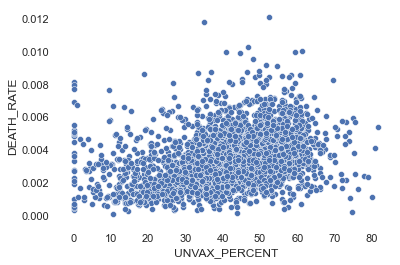

In [67]:
import seaborn as sns

sns.scatterplot(y=joined.DEATH_RATE, x=joined.UNVAX_PERCENT)

In [68]:
import numpy as np

In [69]:
joined.UNVAX_PERCENT.corr(joined.DEATH_RATE)

0.3358558327953451

In [70]:
## there are about a million people in counties reporting 0 fatalities 
# (which must be a reporting error)

joined[joined.DEATH_RATE == 0].sort_values('POPN', ascending=False)

,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE
FIPS,,,,,,


In [71]:
## OK, now let's pull in county level GDP and see how the correlation goes

"""
gdp_table <- read_html("https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income") %>%
        html_element(xpath = "//table[3]") %>%
        html_table() 
        #%>%
        #mutate(CountyState = paste("County or county-equivalent", ", ", "State, federal district or territory"))

colnames(gdp_table) <- c("Rank", "County", "State",
        "PerCapita", "MedianHousehold", "MedianFamily", "Population", "NumHouseholds")
"""

#per_capita = "https://en.wikipedia.org/wiki/List_of_United_States_counties_by_per_capita_income"

per_capita = "percapita.html" # TODO: remove cache

conversions = {
                'Population': int,
                'Number ofhouseholds': int
                }

html_crud = pd.read_html(per_capita)[2]

# this will make rows with "-" in them be nan
html_crud['Rank'] = pd.to_numeric(html_crud['Rank'], errors="coerce")

html_crud = html_crud.dropna()

## deal with dollar signs, y'all
# taken from: https://stackoverflow.com/questions/32464280/converting-currency-with-to-numbers-in-python-pandas

dollar_values = ['Per capitaincome', 'Medianhouseholdincome', 'Medianfamilyincome']


for v in dollar_values:
    html_crud[v] = html_crud[v].str.replace(r"[$,]", "", regex=True).astype(int)

html_crud = html_crud.dropna()

html_crud = html_crud.rename(columns = {
                                'County or county-equivalent': 'COUNTY',
                                'Per capitaincome': 'PER_CAPITA', 
                                'Medianhouseholdincome': 'MEDIAN_HOUSEHOLD',  
                                'Medianfamilyincome': 'MEDIAN_FAMILY',
                                'State, federal district or territory': 'STATE',
                                'Population': 'POPULATION',
                                'Number ofhouseholds': 'HOUSEHOLDS',
                                'Rank': 'PER_CAPITA_RANK'}).astype({'POPULATION': int, 'HOUSEHOLDS': int})

html_crud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3143 entries, 0 to 3267
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PER_CAPITA_RANK   3143 non-null   float64
 1   COUNTY            3143 non-null   object 
 2   STATE             3143 non-null   object 
 3   PER_CAPITA        3143 non-null   int64  
 4   MEDIAN_HOUSEHOLD  3143 non-null   int64  
 5   MEDIAN_FAMILY     3143 non-null   int64  
 6   POPULATION        3143 non-null   int64  
 7   HOUSEHOLDS        3143 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 221.0+ KB


In [72]:
df2 = joined.reset_index().merge(html_crud, on=['STATE', 'COUNTY'])

In [73]:
df2

,FIPS,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE,PER_CAPITA_RANK,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
0,1001.0,Autauga,Alabama,194,55869.0,45.153842,0.003472,1142.0,24571,53682,66349,54907,20071
1,1003.0,Baldwin,Alabama,640,223234.0,36.427695,0.002867,694.0,26766,50221,60864,187114,73283
2,1005.0,Barbour,Alabama,93,24686.0,44.989063,0.003767,2947.0,16829,32911,43462,27321,9200
3,1007.0,Bibb,Alabama,99,22394.0,57.778869,0.004421,2865.0,17427,36447,43004,22754,7091
4,1009.0,Blount,Alabama,218,57826.0,62.065507,0.003770,2150.0,20730,44145,52996,57623,21108
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,56037.0,Sweetwater,Wyoming,123,42343.0,42.032922,0.002905,300.0,30517,71525,81595,44437,16682
2913,56039.0,Teton,Wyoming,16,23464.0,0.000000,0.000682,29.0,43444,68078,83558,21575,7583
2914,56041.0,Uinta,Wyoming,36,20226.0,41.031346,0.001780,942.0,25513,58515,73060,21040,7290
2915,56043.0,Washakie,Wyoming,43,7805.0,53.440102,0.005509,459.0,28308,47104,64608,8468,3468


<AxesSubplot:xlabel='PER_CAPITA', ylabel='DEATH_RATE'>

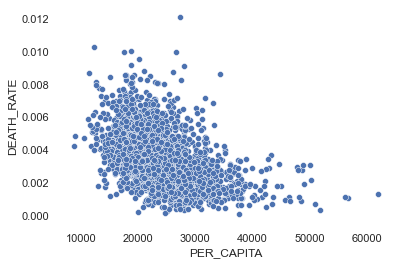

In [74]:

sns.set(rc={'axes.facecolor': 'white'})

sns.scatterplot(x=df2.PER_CAPITA, y=df2.DEATH_RATE)

# import matplotlib.pyplot as plt
# ax = plt.axes()

# ax.set_facecolor('white')

<AxesSubplot:xlabel='UNVAX_PERCENT', ylabel='PER_CAPITA'>

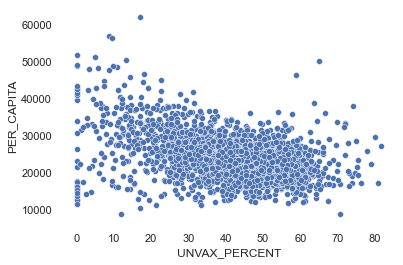

In [75]:
sns.scatterplot(x=df2.UNVAX_PERCENT, y=df2.PER_CAPITA)

In [76]:
df2.UNVAX_PERCENT.corr(df2.PER_CAPITA)

-0.4494031599349531

In [77]:
### now time to get community health rankings pulled in...

#ch_rankings = pd.read_excel("2021 County Health Rankings Data - v1.xlsx")

In [78]:
## TODO: get original link in here

cols = {
    'Rank':     'HEALTH_OUTCOMES_RANK',
    'Quartile': 'HEALTH_OUTCOMES_QUARTILE',
    'Rank.1':   'HEALTH_FACTORS_RANK',
    'Quartile.1':'HEALTH_FACTORS_QUARTILE'
}

ts = {
    'HEALTH_OUTCOMES_RANK': float,
    'HEALTH_OUTCOMES_QUARTILE': float,
    'HEALTH_FACTORS_RANK': float,
    'HEALTH_FACTORS_QUARTILE': float
}

xls = pd.ExcelFile("2021 County Health Rankings Data - v1.xlsx")



ch_rankings = pd.read_excel(xls, "Outcomes & Factors Rankings", header=1)

#
ch_rankings = ch_rankings[ch_rankings['Rank'] != 'NR']

ch_rankings = ch_rankings.rename(columns=cols).astype(ts).dropna()

ch_rankings


,FIPS,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE
1,1001,Alabama,Autauga,67,6.0,1.0,9.0,1.0
2,1003,Alabama,Baldwin,67,2.0,1.0,3.0,1.0
3,1005,Alabama,Barbour,67,51.0,4.0,59.0,4.0
4,1007,Alabama,Bibb,67,45.0,3.0,42.0,3.0
5,1009,Alabama,Blount,67,23.0,2.0,25.0,2.0
...,...,...,...,...,...,...,...,...
3188,56037,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0
3189,56039,Wyoming,Teton,23,1.0,1.0,1.0,1.0
3190,56041,Wyoming,Uinta,23,21.0,4.0,14.0,3.0
3191,56043,Wyoming,Washakie,23,11.0,2.0,15.0,3.0


In [79]:


final_df = ch_rankings.set_index("FIPS").join(df2.set_index("FIPS"))

final_df

,State,County,# of Ranked Counties,HEALTH_OUTCOMES_RANK,HEALTH_OUTCOMES_QUARTILE,HEALTH_FACTORS_RANK,HEALTH_FACTORS_QUARTILE,COUNTY,STATE,DEATHS,POPN,UNVAX_PERCENT,DEATH_RATE,PER_CAPITA_RANK,PER_CAPITA,MEDIAN_HOUSEHOLD,MEDIAN_FAMILY,POPULATION,HOUSEHOLDS
FIPS,,,,,,,,,,,,,,,,,,,
1001.0,Alabama,Autauga,67,6.0,1.0,9.0,1.0,Autauga,Alabama,194.0,55869.0,45.153842,0.003472,1142.0,24571.0,53682.0,66349.0,54907.0,20071.0
1003.0,Alabama,Baldwin,67,2.0,1.0,3.0,1.0,Baldwin,Alabama,640.0,223234.0,36.427695,0.002867,694.0,26766.0,50221.0,60864.0,187114.0,73283.0
1005.0,Alabama,Barbour,67,51.0,4.0,59.0,4.0,Barbour,Alabama,93.0,24686.0,44.989063,0.003767,2947.0,16829.0,32911.0,43462.0,27321.0,9200.0
1007.0,Alabama,Bibb,67,45.0,3.0,42.0,3.0,Bibb,Alabama,99.0,22394.0,57.778869,0.004421,2865.0,17427.0,36447.0,43004.0,22754.0,7091.0
1009.0,Alabama,Blount,67,23.0,2.0,25.0,2.0,Blount,Alabama,218.0,57826.0,62.065507,0.003770,2150.0,20730.0,44145.0,52996.0,57623.0,21108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037.0,Wyoming,Sweetwater,23,17.0,3.0,11.0,2.0,Sweetwater,Wyoming,123.0,42343.0,42.032922,0.002905,300.0,30517.0,71525.0,81595.0,44437.0,16682.0
56039.0,Wyoming,Teton,23,1.0,1.0,1.0,1.0,Teton,Wyoming,16.0,23464.0,0.000000,0.000682,29.0,43444.0,68078.0,83558.0,21575.0,7583.0
56041.0,Wyoming,Uinta,23,21.0,4.0,14.0,3.0,Uinta,Wyoming,36.0,20226.0,41.031346,0.001780,942.0,25513.0,58515.0,73060.0,21040.0,7290.0


<AxesSubplot:xlabel='HEALTH_OUTCOMES_QUARTILE', ylabel='DEATH_RATE'>

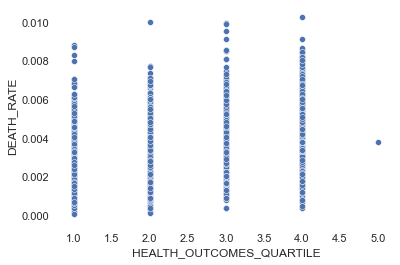

In [80]:
sns.scatterplot(x=final_df.HEALTH_OUTCOMES_QUARTILE, y=final_df.DEATH_RATE)

In [81]:
final_df.UNVAX_PERCENT.corr(final_df.HEALTH_FACTORS_QUARTILE)

0.21073396516317894

In [82]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3081 entries, 1001.0 to 56045.0
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   State                     3081 non-null   object 
 1   County                    3081 non-null   object 
 2   # of Ranked Counties      3081 non-null   int64  
 3   HEALTH_OUTCOMES_RANK      3081 non-null   float64
 4   HEALTH_OUTCOMES_QUARTILE  3081 non-null   float64
 5   HEALTH_FACTORS_RANK       3081 non-null   float64
 6   HEALTH_FACTORS_QUARTILE   3081 non-null   float64
 7   COUNTY                    2880 non-null   object 
 8   STATE                     2880 non-null   object 
 9   DEATHS                    2880 non-null   float64
 10  POPN                      2880 non-null   float64
 11  UNVAX_PERCENT             2880 non-null   float64
 12  DEATH_RATE                2880 non-null   float64
 13  PER_CAPITA_RANK           2880 non-null   float64
 14

In [83]:
big_counties = final_df[final_df.POPULATION > 50000]

small_counties = final_df.drop(big_counties.index)



print(big_counties.UNVAX_PERCENT.corr(big_counties.DEATH_RATE))

print(small_counties.UNVAX_PERCENT.corr(small_counties.DEATH_RATE))

print(big_counties.MEDIAN_HOUSEHOLD.corr(big_counties.DEATH_RATE))

print(small_counties.MEDIAN_HOUSEHOLD.corr(small_counties.DEATH_RATE))

## construct a linear model for DEATH_RATE based on POPULATION

#sns.histplot(final_df.POPULATION - final_df.POPN)

big_counties.corr().DEATH_RATE

0.35140768622331786
0.23296138703552363
-0.48938294674575816
-0.4304390695820182


# of Ranked Counties        0.136450
HEALTH_OUTCOMES_RANK        0.438867
HEALTH_OUTCOMES_QUARTILE    0.414154
HEALTH_FACTORS_RANK         0.400830
HEALTH_FACTORS_QUARTILE     0.393575
DEATHS                      0.083592
POPN                       -0.090769
UNVAX_PERCENT               0.351408
DEATH_RATE                  1.000000
PER_CAPITA_RANK             0.532446
PER_CAPITA                 -0.488600
MEDIAN_HOUSEHOLD           -0.489383
MEDIAN_FAMILY              -0.535047
POPULATION                 -0.079094
HOUSEHOLDS                 -0.084882
Name: DEATH_RATE, dtype: float64

In [84]:
small_counties.corr().DEATH_RATE

# of Ranked Counties        0.288116
HEALTH_OUTCOMES_RANK        0.386281
HEALTH_OUTCOMES_QUARTILE    0.256034
HEALTH_FACTORS_RANK         0.357184
HEALTH_FACTORS_QUARTILE     0.226016
DEATHS                      0.314905
POPN                       -0.158312
UNVAX_PERCENT               0.232961
DEATH_RATE                  1.000000
PER_CAPITA_RANK             0.391703
PER_CAPITA                 -0.397467
MEDIAN_HOUSEHOLD           -0.430439
MEDIAN_FAMILY              -0.428861
POPULATION                 -0.126760
HOUSEHOLDS                 -0.140227
Name: DEATH_RATE, dtype: float64

In [85]:
gaz = pd.read_csv("2021_Gaz_counties_national.txt", delimiter="\t").rename(columns={'GEOID': 'FIPS'}).set_index("FIPS")

gaz = gaz[["ALAND_SQMI"]]

gaz


,ALAND_SQMI
FIPS,
1001,594.456
1003,1589.836
1005,885.008
1007,622.470
1009,644.891
...,...
72145,45.848
72147,50.788
72149,35.637


In [86]:
final_df = final_df.join(gaz)



In [88]:
final_df['DENSITY'] = final_df.POPULATION / final_df.ALAND_SQMI

In [90]:
final_df.corr().DENSITY

# of Ranked Counties       -0.054523
HEALTH_OUTCOMES_RANK       -0.077555
HEALTH_OUTCOMES_QUARTILE   -0.061757
HEALTH_FACTORS_RANK        -0.072367
HEALTH_FACTORS_QUARTILE    -0.034890
DEATHS                      0.482613
POPN                        0.394080
UNVAX_PERCENT              -0.226794
DEATH_RATE                 -0.045674
PER_CAPITA_RANK            -0.135666
PER_CAPITA                  0.180180
MEDIAN_HOUSEHOLD            0.147752
MEDIAN_FAMILY               0.141034
POPULATION                  0.402163
HOUSEHOLDS                  0.416539
ALAND_SQMI                 -0.044344
DENSITY                     1.000000
Name: DENSITY, dtype: float64

In [105]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X = final_df
Y = final_df.DEATH_RATE

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
        test_size=0.20, random_state = 123) 

#model = smf.ols(formula='DEATH_RATE ~ MEDIAN_FAMILY + HEALTH_FACTORS_RANK', data=X_train).fit()

factors = ['HEALTH_FACTORS_RANK', 'UNVAX_PERCENT', 'DENSITY']

best = ['', 0]
for f in factors:
        f_str = f'DEATH_RATE ~ MEDIAN_FAMILY + HEALTH_OUTCOMES_RANK + {f}'
        this_model = smf.ols(formula=f_str, data=X_train).fit()
        if this_model.rsquared > best[1]:
                best = [f, this_model.rsquared]


print(best)

#print(model.summary())



['UNVAX_PERCENT', 0.32442106827448336]


In [99]:
final_df.corr().DEATH_RATE

# of Ranked Counties        0.272219
HEALTH_OUTCOMES_RANK        0.443217
HEALTH_OUTCOMES_QUARTILE    0.343692
HEALTH_FACTORS_RANK         0.418666
HEALTH_FACTORS_QUARTILE     0.330310
DEATHS                     -0.050460
POPN                       -0.148731
UNVAX_PERCENT               0.341534
DEATH_RATE                  1.000000
PER_CAPITA_RANK             0.484043
PER_CAPITA                 -0.473409
MEDIAN_HOUSEHOLD           -0.492780
MEDIAN_FAMILY              -0.506059
POPULATION                 -0.141792
HOUSEHOLDS                 -0.149882
ALAND_SQMI                 -0.061611
DENSITY                    -0.045674
Name: DEATH_RATE, dtype: float64